In [1]:
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.library import MCMT

from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import numpy as np
import matplotlib.pyplot as plt
import math

sim = Aer.get_backend('aer_simulator')
sim.set_options(device='GPU')

# using tikzplotlib to export plot to latex
import tikzplotlib

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

def save_fig(name, width='10cm', height='10cm'):
    fig = plt.gcf()
    tikzplotlib_fix_ncols(fig)

    tikzplotlib.clean_figure()
    tikzplotlib.save(name + '.tex', axis_width=width, axis_height=height)

In [2]:
sudoku = [[1, 0, 0, 0],
          [0, 0, 0, 4],
          [0, 0, 2, 0],
          [0, 3, 0, 0]]

In [3]:
inconnue = (4**2 - 4) * 2 
print(inconnue)

cond_line = (3 + 2 + 1) * 2 * 4
cond_column = cond_line
cond_square = cond_line

total_cond = cond_line + cond_column + cond_square
print(total_cond)

verif_cond = int(total_cond / 2)
print(verif_cond)

print(inconnue + total_cond + verif_cond)

24
144
72
240


In [4]:
num_rep = int(np.floor(np.pi / 4 * np.sqrt(2**inconnue)))
print(num_rep)

3216


In [5]:
entry = QuantumRegister(inconnue, 'entry')
cond = QuantumRegister(total_cond, 'cond')
verif = QuantumRegister(verif_cond, 'verif')
out = QuantumRegister(1, 'out')

In [6]:
def diffuser(nqubits):
    qc_diff = QuantumCircuit(nqubits)
    qc_diff.h(range(nqubits))
    qc_diff.x(range(nqubits))
    
    qc_diff.h(nqubits - 1)
    qc_diff.mct(list(range(nqubits - 1)), nqubits - 1)
    qc_diff.h(nqubits - 1)
    
    qc_diff.x(range(nqubits))
    qc_diff.h(range(nqubits))
    return qc_diff

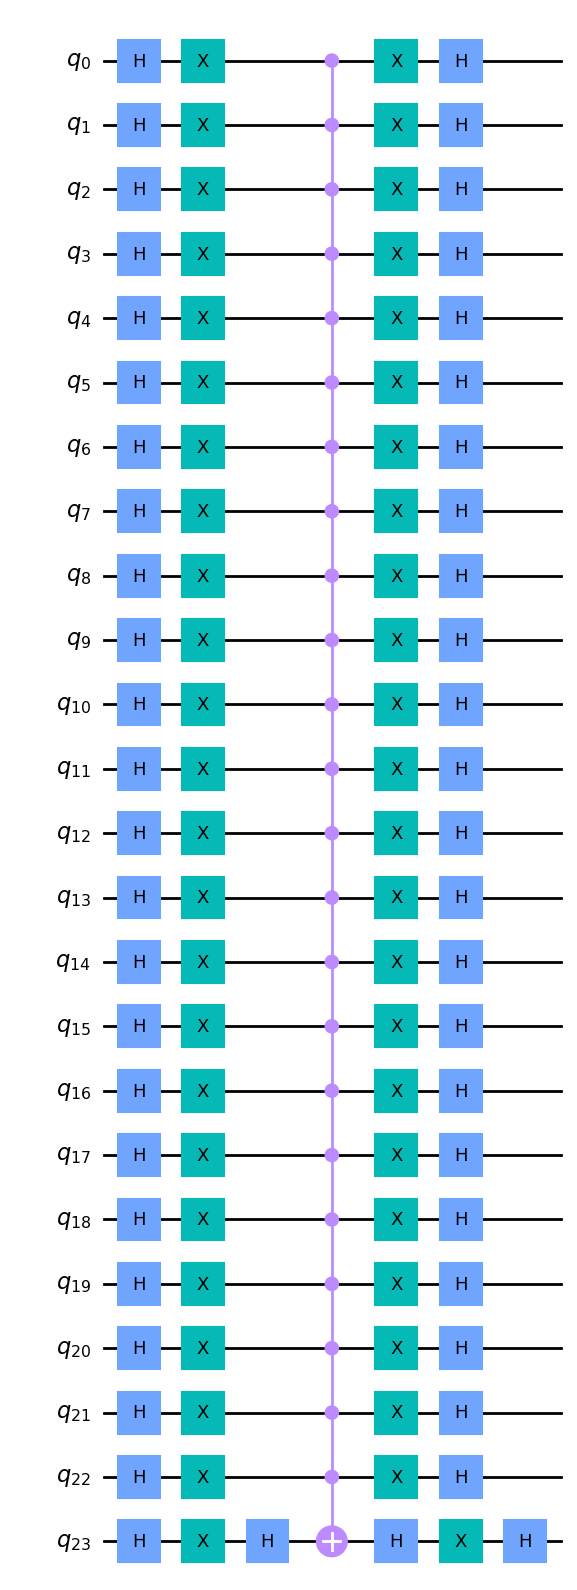

In [7]:
diffuser(inconnue).draw('mpl')

In [8]:
print(diffuser(5).draw('mpl'))

Figure(705.552x451.5)


In [9]:
# en output : 01 : 1, 10 : 2, 11 : 3, 00 : 4

def grid_check(line, col):
    if (line % 2) == 0 and (col % 2) == 0:
        return 0
    if (line % 2) == 0 and (col % 2) == 1:
        return 1
    if (line % 2) == 1 and (col % 2) == 0:
        return 2
    if (line % 2) == 1 and (col % 2) == 1:
        return 3

def sudoku_oracle(sudoku_grid):
    num_empty = 0
    
    qc_oracle = QuantumCircuit(entry, cond, verif, out)
    
    for grid_line in range(len(sudoku_grid)):
        for grid_column in range(len(sudoku_grid[grid_line])):
            # conditions for line and column
            for alternate in [0, cond_line]:
                match sudoku_grid[grid_line][grid_column]:
                    case 1:
                        qc_oracle.x(cond[2 * grid_line + (3 + 2 + 1) * 2 * grid_column + alternate])
                    case 2:
                        qc_oracle.x(cond[2 * grid_line + 1 + (3 + 2 + 1) * 2 * grid_column + alternate])
                    case 3:
                        qc_oracle.x(cond[2 * grid_line + (3 + 2 + 1) * 2 * grid_column + alternate])
                        qc_oracle.x(cond[2 * grid_line + 1 + (3 + 2 + 1) * 2 * grid_column + alternate])
                    case 4:
                        pass
                    case 0:
                        qc_oracle.cx(entry[num_empty], cond[2 * grid_line + (3 + 2 + 1) * 2 * grid_column + alternate])
                        qc_oracle.cx(entry[num_empty + 1], cond[2 * grid_line + 1 + (3 + 2 + 1) * 2 * grid_column + alternate])    
                   
            # conditions for square       
            match sudoku_grid[grid_line][grid_column]:
                case 1:
                    qc_oracle.x(cond[2 * grid_check(grid_line, grid_column) + cond_line + cond_column + (3 + 2 + 1) * 2 * grid_check(grid_line, grid_column)])
                case 2:
                    qc_oracle.x(cond[2 * grid_check(grid_line, grid_column) + 1 + cond_line + cond_column + (3 + 2 + 1) * 2 * grid_check(grid_line, grid_column)])
                case 3:
                    qc_oracle.x(cond[2 * grid_check(grid_line, grid_column) + cond_line + cond_column + (3 + 2 + 1) * 2 * grid_check(grid_line, grid_column)])
                    qc_oracle.x(cond[2 * grid_check(grid_line, grid_column) + cond_line + cond_column + (3 + 2 + 1) * 2 * grid_check(grid_line, grid_column)])
                case 4:
                    pass
                case 0:
                    qc_oracle.cx(entry[num_empty], cond[2 * grid_check(grid_line, grid_column) + cond_line + cond_column + (3 + 2 + 1) * 2 * grid_check(grid_line, grid_column)])
                    qc_oracle.cx(entry[num_empty + 1], cond[2 * grid_check(grid_line, grid_column) + 1 + cond_line + cond_column + (3 + 2 + 1) * 2 * grid_check(grid_line, grid_column)])

            if sudoku_grid[grid_line][grid_column] == 0:
                num_empty += 2

    for i in range(verif_cond):
        qc_oracle.cx(cond[2*i], verif[i])
        qc_oracle.cx(cond[2*i + 1], verif[i])
                
    qc_rep = qc_oracle.to_gate(label='rep')
    
    qc_oracle.compose(MCMT('x', verif_cond, 1), range(inconnue + total_cond, inconnue + total_cond + verif_cond + 1), inplace=True)
    qc_oracle.append(qc_rep, entry[:] + cond[:] + verif[:] + out[:])

    return qc_oracle   

In [10]:
# sudoku_oracle(sudoku).draw('mpl')
print(sudoku_oracle(sudoku).draw('latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{entry}_{0} :  } & \lstick{{entry}_{0} :  } & \qw & \ctrl{36} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \ctrl{84} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \ctrl{134} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \

In [11]:
print('début 0/?')
oracle_gate = sudoku_oracle(sudoku).to_gate(label='oracle')
print('oracle construit 1/?')
diffuser_gate = diffuser(inconnue).to_gate(label='diffuser')
print('diffuser construit 2/?')

output = ClassicalRegister(inconnue, 'output')
print('creation output 3/?')

qc_total = QuantumCircuit(entry, cond, verif, out, output)
print('qc_total construit 4/?')

qc_total.h(entry)
print('qc_total h 5/?')

qc_total.barrier()
print('qc_total barrier 6/?')

# for i in range(num_rep):
#     qc_total.append(oracle_gate, entry[:] + cond[:] + verif[:] + out[:])
#     print('qc_total oracle 7/? :', i)
#     qc_total.append(diffuser_gate, entry[:])
#     print('qc_total diffuser 8/? :', i)

# test avec 1 seule répétition
qc_total.append(oracle_gate, entry[:] + cond[:] + verif[:] + out[:])
print('qc_total oracle 7/?')
qc_total.append(diffuser_gate, entry[:])
print('qc_total diffuser 8/?')
    
qc_total.measure(entry, output)
print('qc_total measure 9/?')

début 0/?
oracle construit 1/?
diffuser construit 2/?
creation output 3/?
qc_total construit 4/?
qc_total h 5/?
qc_total barrier 6/?
qc_total oracle 7/?
qc_total diffuser 8/?
qc_total measure 9/?


In [12]:
print(qc_total.draw(output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{entry}_{0} :  } & \lstick{{entry}_{0} :  } & \gate{\mathrm{H}} \barrier[0em]{240} & \qw & \multigate{240}{\mathrm{oracle}}_<<<{0} & \multigate{23}{\mathrm{diffuser}}_<<<{0} & \meter & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{entry}_{1} :  } & \lstick{{entry}_{1} :  } & \gate{\mathrm{H}} & \qw & \ghost{\mathrm{oracle}}_<<<{1} & \ghost{\mathrm{diffuser}}_<<<{1} & \qw & \meter & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{entry}_{2} :  } & \lstick{{entry}_{2} :  } & \gate{\mathrm{H}} & \qw & \ghost{\mathrm{oracle}}_<<<{2} & \ghost{\mathrm{diffuser}}_<<<{2} & \qw & \qw & \meter & \qw &

In [13]:
from qiskit import IBMQ

# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

backend = provider.get_backend('simulator_stabilizer')

C:\Users\romai\AppData\Local\Temp\ipykernel_16412\207550992.py:4: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account() # Load account from disk
C:\Users\romai\AppData\Local\Temp\ipykernel_16412\207550992.py:4: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account() # Load account from disk


In [14]:
print('debut')
#trans_qc = transpile(qc_total, backend=backend, optimization_level=1)
#print('transpile done')
results = execute(qc_total, backend=backend, shots=512).result()
print('execute done')
counts = results.get_counts()
plot_histogram(counts)

debut


MemoryError: 

In [ ]:
with open('out.txt', 'w+') as f:
    print(counts, file=f)
    
plt.figure(figsize=(10, 10))
plt.barh(list(counts.keys()), list(counts.values()))
save_fig('sudoku_result')